In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
# CSV-Dateien
input_csv = "color_based_classification_updated.csv"  # Original CSV mit Labels
progress_csv = "color_based_classification_progress.csv"  # Speichert den Fortschritt
log_csv = "corrected_labels_log.csv"  # Speichert alle Änderungen
final_csv = "color_based_classification_final.csv"
max_width = 1000  # maximale Bildbreite in Pixeln


# CSV laden oder Fortschritt fortsetzen
if os.path.exists(progress_csv):
    df = pd.read_csv(progress_csv)
    print("⏳ Fortschritt wird fortgesetzt...")
else:
    df = pd.read_csv(input_csv)
    df["Checked"] = False

corrections = []

# Bilder durchgehen
for index, row in df.iterrows():
    if row["Checked"]:
        continue

    img_path = row["Image Path"]
    old_label = row["Classification"]

    if not os.path.exists(img_path):
        print(f"⚠️ Bild nicht gefunden: {img_path}")
        continue

    # Bild laden
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Bild konnte nicht geladen werden: {img_path}")
        continue

    # Bild ggf. skalieren
    height, width = img.shape[:2]
    if width > max_width:
        scale = max_width / width
        new_size = (int(width * scale), int(height * scale))
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # Bild anzeigen
    cv2.imshow(f"Bild {index + 1} von {len(df)} | Label: {old_label}", img)
    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Abbruch mit 'q'
    if key == ord("q"):
        print("Vorgang abgebrochen. Fortschritt gespeichert.")
        break

    # Label-Eingabe
    new_label = old_label
    if key == ord("d"):
        new_label = "Day"
    elif key == ord("n"):
        new_label = "Night"

    # Änderung speichern
    if new_label != old_label:
        df.at[index, "Classification"] = new_label
        corrections.append([img_path, old_label, new_label])

    # Fortschritt speichern
    df.at[index, "Checked"] = True
    df.to_csv(progress_csv, index=False)

# Final speichern
df.to_csv(final_csv, index=False)
print(f"Finale Datei gespeichert: {final_csv}")

if corrections:
    log_df = pd.DataFrame(corrections, columns=["Image Path", "Old Label", "New Label"])
    log_df.to_csv(log_csv, index=False)
    print(f"📄 Änderungen gespeichert in: {log_csv}")
else:
    print("ℹKeine Änderungen vorgenommen.")

In [16]:
# Verteilung der Labels anzeigen
label_counts = df["Classification"].value_counts()
print("\nVerteilung der Labels:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({(count / len(df)) * 100:.2f}%)")



Verteilung der Labels:
Day: 6253 (62.57%)
Night: 3740 (37.43%)


Länge der aktualisierten CSV: 9993
Länge der finalen CSV: 9993
Anzahl der Bilder gemerged: 9993
Übereinstimmungen: 9847
Fehlklassifikationen: 146
Übereinstimmungsrate: 98.54%


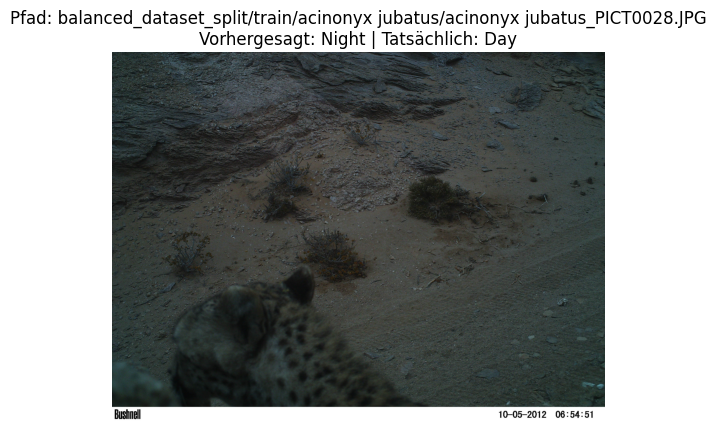

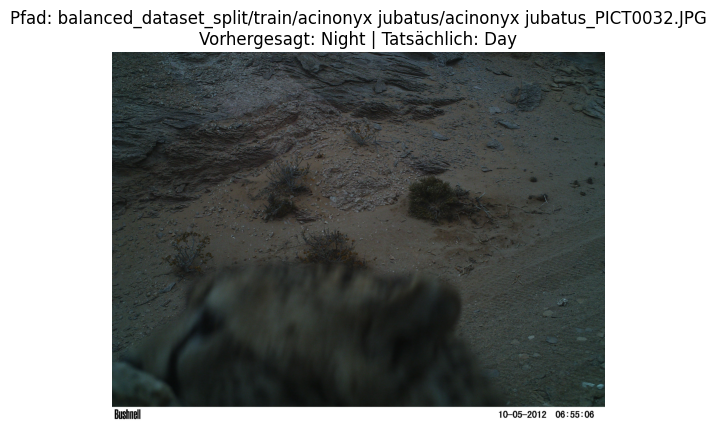

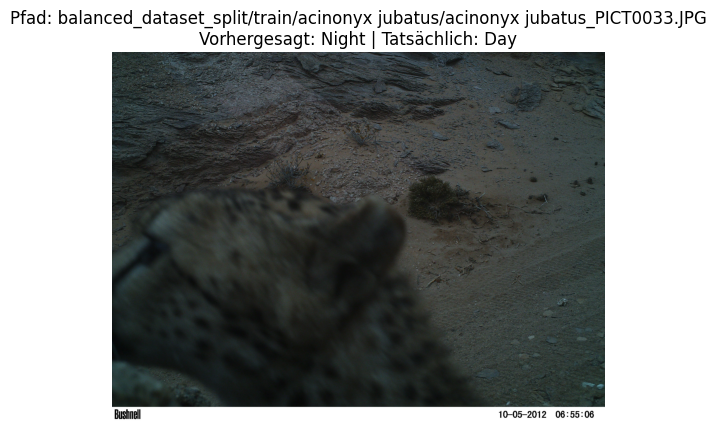

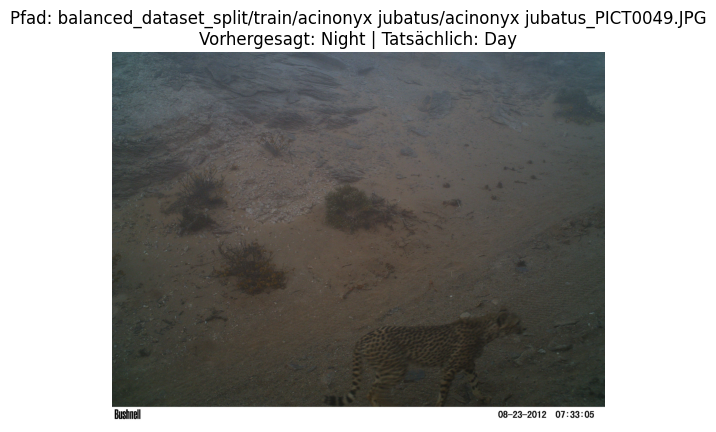

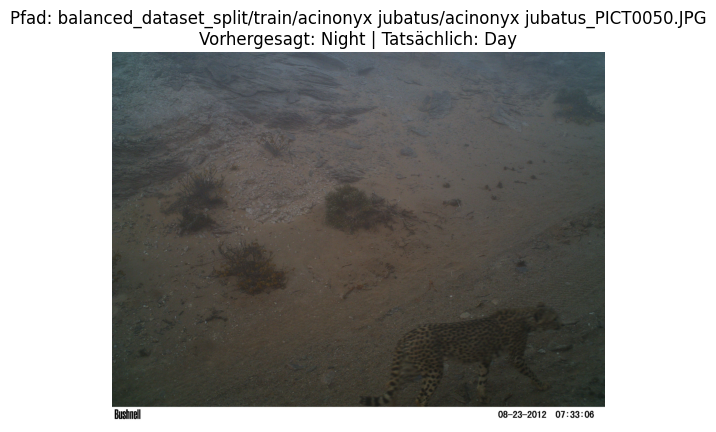

In [2]:
# CSV-Dateien laden
df_updated = pd.read_csv("color_based_classification_updated.csv")
df_final = pd.read_csv("color_based_classification_final.csv")

# Debug-Ausgaben zur Anzahl der Einträge
print(f"Länge der aktualisierten CSV: {len(df_updated)}")
print(f"Länge der finalen CSV: {len(df_final)}")

# Zusammenführen über den Bildpfad
merged_df = pd.merge(
    df_updated,
    df_final,
    on="Image Path",
    suffixes=('_updated', '_final')
)

# Debug-Ausgabe zur Merge-Größe
print(f"Anzahl der Bilder gemerged: {len(merged_df)}")

# Neue Spalte: ob Klassifikation übereinstimmt
merged_df["Match"] = merged_df["Classification_updated"] == merged_df["Classification_final"]

# Statistiken berechnen
total = len(merged_df)
matches = merged_df["Match"].sum()
misses = total - matches
accuracy = matches / total * 100

# Ergebnisse anzeigen
print(f"Übereinstimmungen: {matches}")
print(f"Fehlklassifikationen: {misses}")
print(f"Übereinstimmungsrate: {accuracy:.2f}%")

# Fehlklassifizierte Bilder extrahieren
missclassified = merged_df[~merged_df["Match"]].head(5)

# Bilder anzeigen
for index, row in missclassified.iterrows():
    image_path = row["Image Path"]
    
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f"Pfad: {image_path}\nVorhergesagt: {row['Classification_updated']} | Tatsächlich: {row['Classification_final']}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Bild nicht gefunden: {image_path}")

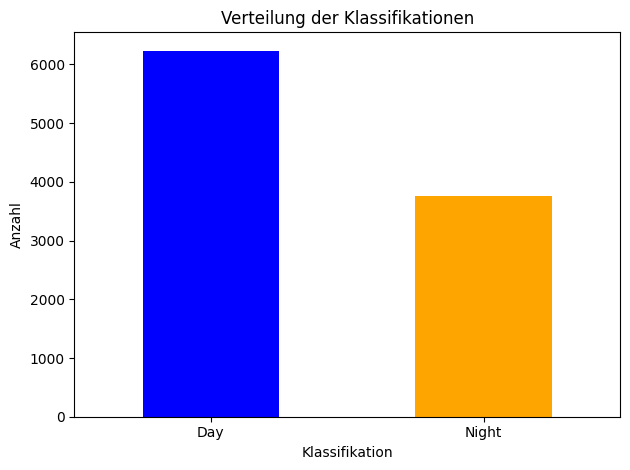

In [17]:
# Verteilung Tag/Nacht anzeigen als Plot
labels = df_final["Classification"].value_counts()
labels.plot(kind='bar', color=['blue', 'orange'])
plt.title("Verteilung der Klassifikationen")
plt.xlabel("Klassifikation")
plt.ylabel("Anzahl")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

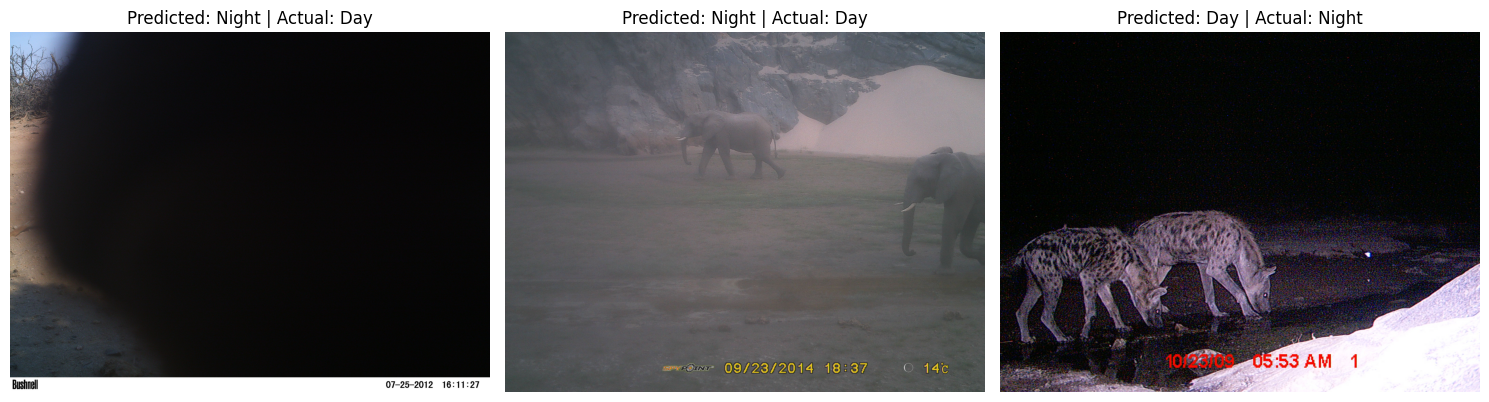

In [ ]:
paths = [
    "balanced_dataset_split/train/crocuta crocuta/crocuta crocuta_Susis Spring 24 October 2009 656.jpg",
    "balanced_dataset_split/train/loxodanta africana/loxodanta africana_20140923-PICT1096.JPG",
    "balanced_dataset_split/train/mellivora capensis/mellivora capensis_PICT0612.JPG"
]# Bildpfade und Labelinfos
images_info = [
    {
        "path": "balanced_dataset_split/train/mellivora capensis/mellivora capensis_PICT0612.JPG",
        "predicted": "Night",
        "actual": "Day"
    },
    {
        "path": "balanced_dataset_split/train/loxodanta africana/loxodanta africana_20140923-PICT1096.JPG",
        "predicted": "Night",
        "actual": "Day"
    },
    {
        "path": "balanced_dataset_split/train/crocuta crocuta/crocuta crocuta_Susis Spring 24 October 2009 656.jpg",
        "predicted": "Day",
        "actual": "Night"
    }
]

# Grafik erstellen
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, info in enumerate(images_info):
    img = mpimg.imread(info["path"])
    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(f"Predicted: {info['predicted']} | Actual: {info['actual']}", fontsize=12)
    ax.set_xlabel(f"Image {idx + 1}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig("figures/misclassified_triplet.pdf", dpi=300)
plt.show()
